# Example ODE

This notebooks addresses the shortcomings of the notebook with a similar name which have to do with applying normalization

We start by importing the required libraries and setting the plotting style:

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
# DeepMoD stuff
import sys
sys.path.append('../src/')
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.training import train_deepmod, train_mse
from deepymod_torch.library_functions import library_1D_in

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2

Next, we prepare the dataset. The set of ODEs we consider here are
$d[y, z]/dt = [z, -z- 5 \sin y]$

In [2]:
def dU_dt_true(U):
    """
    returns the right hand side of the differential equation"""
    return [U[1], -1*U[1] - 5*np.sin(U[0])]


def dU_dt_sin(U, t):
    """
    returns the right hand side of the differential equation"""
    return dU_dt_true(U)
U0 = [2.5, 0.4]
ts = np.linspace(0, 8, 500)
Y = odeint(dU_dt_sin, U0, ts)
T = ts.reshape(-1,1)

Here we can potentially rescale the Y and T axis and we plot the results

In [3]:
T_rs = T
Y_rs = Y #Y/np.max(np.abs(Y),axis=0)

Let's plot it to get an idea of the data:

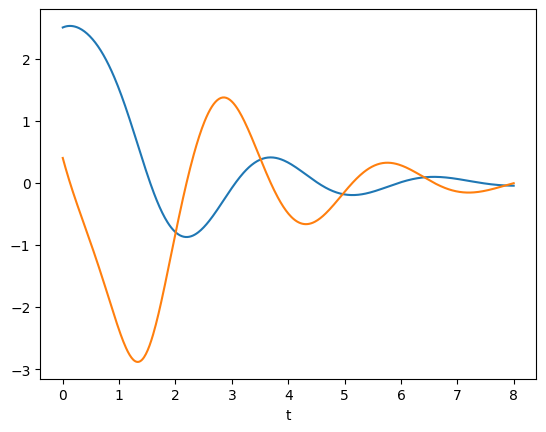

In [4]:
fig, ax = plt.subplots()
ax.plot(T_rs, Y_rs[:,0])
ax.plot(T_rs, Y_rs[:,1])
ax.set_xlabel('t')

plt.show()

In [5]:
number_of_samples = 400

idx = np.random.permutation(Y.shape[0])
X_train = torch.tensor(T_rs[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(Y_rs[idx, :][:number_of_samples], dtype=torch.float32)

In [6]:
print(X_train.shape, y_train.shape)

torch.Size([400, 1]) torch.Size([400, 2])


# Setup a custom library

In [7]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce

Here we show an example where we create a custom library. $\theta$ in this case containe $[1,u,v, cos(u),sin(u)]$ to showcase that non-linear terms can easily be added to the library

In [8]:
def library_non_linear_ODE(input, poly_order, diff_order):
    
    prediction, data = input
    samples = prediction.shape[0]
    
    # Construct the theta matrix
    C = torch.ones_like(prediction[:,0]).view(samples, -1)
    u = prediction[:,0].view(samples, -1)
    v = prediction[:,1].view(samples, -1)
    theta = torch.cat((C, u, v, torch.cos(u), torch.sin(u)),dim=1)

    # Construct a list of time_derivatives 
    time_deriv_list = []
    for output in torch.arange(prediction.shape[1]):
        dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True)[0]
        time_deriv = dy[:, 0:1]
        time_deriv_list.append(time_deriv)
        
    return time_deriv_list, theta


## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [9]:
## Running DeepMoD
config = {'n_in': 1, 'hidden_dims': [40, 40, 40, 40, 40, 40], 'n_out': 2, 'library_function': library_non_linear_ODE, 'library_args':{'poly_order': 1, 'diff_order': 0}}

Now we instantiate the model. Note that the learning rate of the coefficient vector can typically be set up to an order of magnitude higher to speed up convergence without loss in accuracy

In [10]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}])

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [11]:
%%time
train_deepmod(model, X_train, y_train, optimizer, 50000, {'l1': 1e-5})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      50000    100.00%               0s   5.70e-05   1.18e-05   1.81e-05   2.72e-05 
[Parameter containing:
tensor([[1.0002]], requires_grad=True), Parameter containing:
tensor([[-0.9994],
        [-4.9970]], requires_grad=True)]
[tensor([2]), tensor([2, 4])]

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      50000    100.00%               0s   4.05e-05   1.69e-05   2.36e-05   0.00e+00 CPU times: user 9min 43s, sys: 7.32 s, total: 9min 50s
Wall time: 9min 49s


Now that DeepMoD has converged, it has found the following numbers:

In [12]:
solution = model(X_train)[0].detach().numpy()
solution_derivatives = np.transpose(np.array([timeder.detach().numpy().squeeze() for timeder in model(X_train)[1]]))

In [18]:
time_deriv, theta = model.library((model.network(X_train),X_train))
len(time_deriv), theta.shape

(2, torch.Size([400, 5]))

$\theta$ in this case contains $[1,u,v, cos(u),sin(u)]$. The form of the discovered equation is

In [17]:
library = ['','+u','+v','+cos(u)','+sin(u)']
ders = ['u_t','v_t']
for sparse, coeff_vector, der in zip(model.fit.sparsity_mask,model.fit.coeff_vector,ders):
    expression = ''
    for sparse_element, coeff in zip(sparse.detach().numpy(),coeff_vector.detach().numpy()):
        expression += ' +'+str(coeff)+library[sparse_element]
    print(der,' =',expression, '\t')

u_t  =  +[1.0001938]+v 	
v_t  =  +[-0.99937963]+v +[-4.9969854]+sin(u) 	


This corresponds to the right ODE

We check that the model consistently evaluates the derivatives:

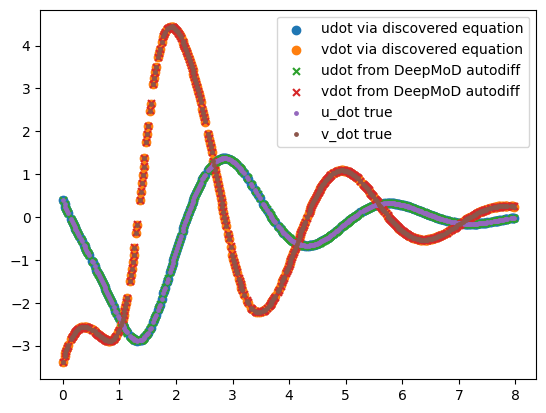

In [19]:
def dU_dt_estimate(U):
    TH = [1, U[0], U[1], np.cos(U[0]), np.sin(U[0])]
    output = []
    for sparse, coeff_vector in zip(model.fit.sparsity_mask,model.fit.coeff_vector):
        expression = 0
        for sparse_element, coeff in zip(sparse.detach().numpy(),coeff_vector.detach().numpy()):
            expression += coeff.item()*TH[sparse_element]
        output.append(expression)
    # Here U is a vector such that u=U[0] and v=U[1]. This function should return [u', v']
    return output #[1.1369082*U[1], 2.9121633 + (-2.9401846)*np.cos(U[0]) +(-10.048162)*np.sin(U[0])]

result = np.array(list(map(dU_dt_estimate, y_train)))
deriv_eq_true = np.array(list(map(dU_dt_true, y_train)))

plt.scatter(X_train.detach().numpy().squeeze(),result[:,0],label = 'udot via discovered equation')
plt.scatter(X_train.detach().numpy().squeeze(),result[:,1],label = 'vdot via discovered equation')
#plt.scatter(X_train.detach().numpy().squeeze(),solution_derivatives[:,0],s=3) # this line is equivalent to the subsequent one
plt.scatter(X_train.detach().numpy().squeeze(),time_deriv[0].detach().numpy().squeeze(),s=25, label = 'udot from DeepMoD autodiff', marker='x')

#plt.scatter(X_train.detach().numpy().squeeze(),solution_derivatives[:,1],s=3) # this line is equivalent to the subsequent one
plt.scatter(X_train.detach().numpy().squeeze(),time_deriv[1].detach().numpy().squeeze(),s=25, label = 'vdot from DeepMoD autodiff', marker='x')


plt.scatter(X_train.detach().numpy().squeeze(), deriv_eq_true[:,0], label='u_dot true', marker='o', s=6)
plt.scatter(X_train.detach().numpy().squeeze(), deriv_eq_true[:,1], label='v_dot true', marker='o', s=6)
plt.legend()


This looks confusing because the curves don't match

Below we test if the prediction of the model matches the actual rescaled training data

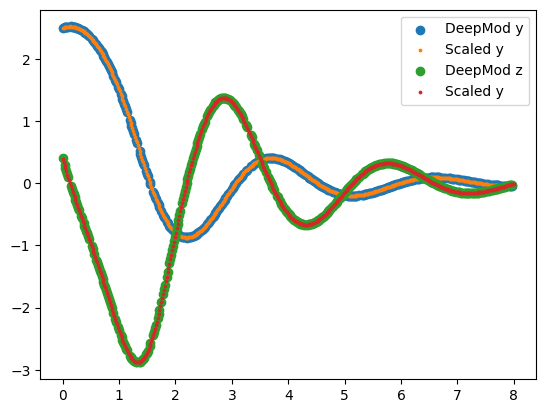

In [15]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,0],label='DeepMod y')
plt.scatter(T_rs,Y_rs[:,0],s=3, label='Scaled y')
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,1], label='DeepMod z')
plt.scatter(T_rs,Y_rs[:,1],s=3, label='Scaled y')
plt.legend()